In [ ]:
%load_ext autoreload
%autoreload 2
%cd /code

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
assert tf.test.is_gpu_available()

In [4]:
from pathlib import Path

from matplotlib import pyplot as plt

from tensorflow.keras import Sequential, layers, models

from notebooks.unet import model
from notebooks.nuclei_data import Dataset

Showing plot


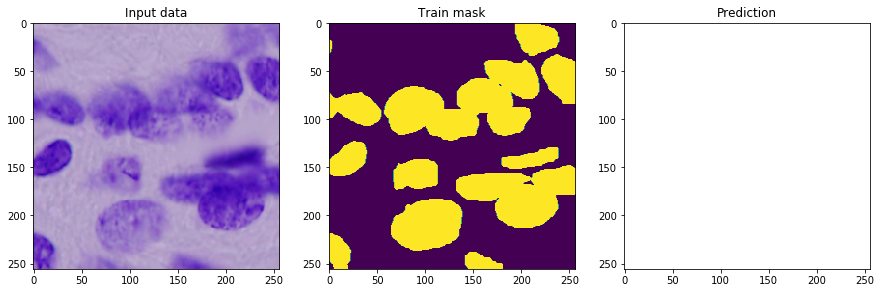

Showing plot


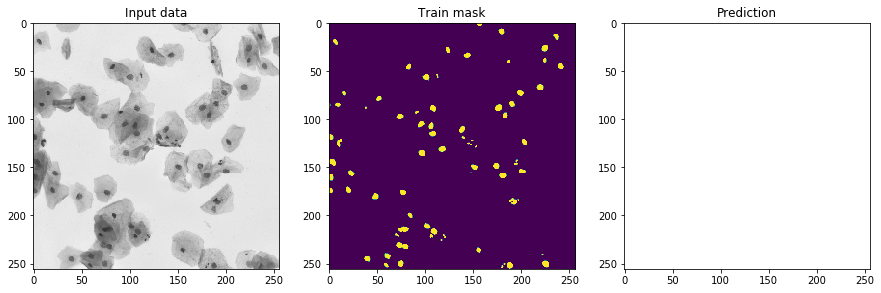

In [5]:
train = Dataset(batch_size=10, directory=Path("/code/data/nuclei/train"), with_mask=True)
train.display(2)
train.display(669)

In [6]:
model.fit(train, epochs=10)

Train on 670 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
670/670 [==============================] - 41s 61ms/sample - loss: 0.4443 - accuracy: 0.8360
Epoch 2/10
670/670 [==============================] - 36s 54ms/sample - loss: 0.2181 - accuracy: 0.9489
Epoch 3/10
670/670 [==============================] - 36s 54ms/sample - loss: 0.1507 - accuracy: 0.9586
Epoch 4/10
670/670 [==============================] - 36s 53ms/sample - loss: 0.1254 - accuracy: 0.9600
Epoch 5/10
670/670 [==============================] - 36s 54ms/sample - loss: 0.1102 - accuracy: 0.9605
Epoch 6/10
670/670 [==============================] - 36s 54ms/sample - loss: 0.1006 - accuracy: 0.9611
Epoch 7/10
670/670 [==============================] - 36s 54ms/sample - loss: 0.0903 - accuracy: 0.9630
Epoch 8/10
670/670 [==============================] - 36s 53ms/sample - loss: 0.0938 - accuracy: 0.9610
Epoch 9/10
670/670 [==============================] -

Showing plot


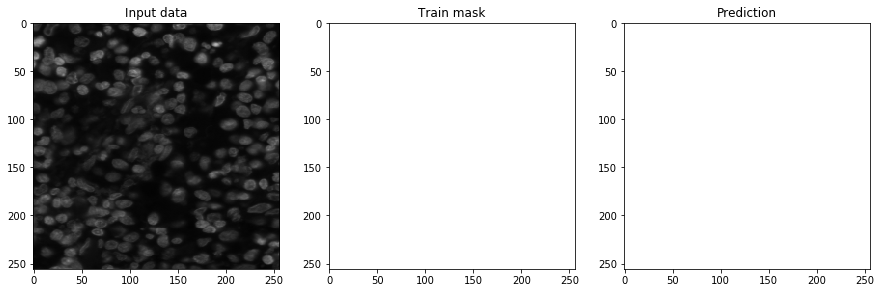

In [7]:
test = Dataset(batch_size=5, directory=Path("/code/data/nuclei/test"), with_mask=False)
test.display(0)

In [8]:
prediction = model.predict(test)

Showing plot


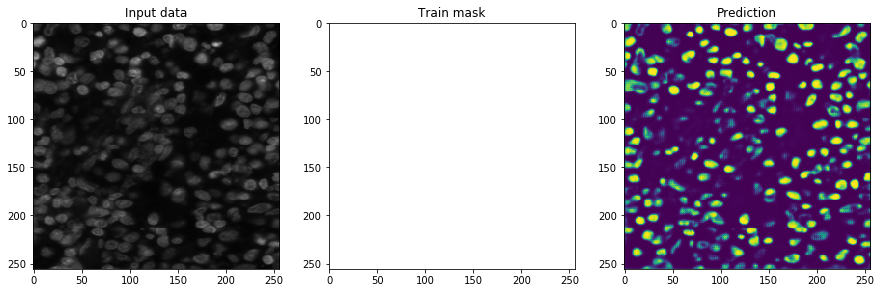

In [10]:
test.display(index=0, prediction=prediction[0])